# E01. Evaluate Games
This evaluates game projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Sportsbook Review
- Dates:
    - Created: 3/30/2024
    - Updated: 5/5/2024

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U4. Datasets.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dates

In [3]:
start_date = "20240101"
end_date = "20240930"
# start_date = todaysdate
# end_date = todaysdate

### Games

In [4]:
%%time
historic_game_df = pd.read_csv(os.path.join(baseball_path, "game_df.csv"))
recent_game_df = create_games(yesterdaysdate, todaysdate, team_dict)
historic_game_df = historic_game_df[~historic_game_df['date'].astype(str).isin([yesterdaysdate, todaysdate])]
all_game_df = pd.concat([historic_game_df, recent_game_df], axis=0)
all_game_df.to_csv(os.path.join(baseball_path, "game_df.csv"), index=False)

CPU times: total: 125 ms
Wall time: 445 ms


In [5]:
game_df = all_game_df[(all_game_df['date'].astype(str) >= start_date) & (all_game_df['date'].astype(str) <= end_date)].reset_index(drop=True)

In [6]:
# game_df = game_df.query('game_date < "20240601"')

### Models

##### Create dataframe containing model information

In [7]:
model_dictionary = {
    "date": todaysdate,
    "batter_stats_scaler_name": "Unavailable", 
    "pitcher_stats_scaler_name": "Unavailable",
    "batter_stats_fg_scaler_name": "Unavailable", 
    "pitcher_stats_fg_scaler_name": "Unavailable",
    "batter_imputations_model_name": "Unavailable", 
    "pitcher_imputations_model_name": "Unavailable", 
    "model_binary_name": "Unavailable", 
    "model_outs_name": "Unavailable", 
    "model_safe_name": "Unavailable",
    "model_errors_name": "Unavailable", 
    "model_dp_name": "Unavailable", 
    "model_out_bases_name": "Unavailable", 
    "model_events_name": "Unavailable", 
    "model_date": "Unavailable", 
    "model_pulls_name": "Unavailable",
    "model_sba_2b_name": "Unavailable", 
    "model_sba_3b_name": "Unavailable", 
    "model_sb_2b_name": "Unavailable", 
    "model_sb_3b_name": "Unavailable",
}

model_df = pd.DataFrame([model_dictionary])

In [8]:
# model_df = pd.DataFrame()

# Functions

##### Calculate gambling stats for sims

In [9]:
def gambling_stats_sim(df):
    ### OU
    # Sim total
    df['total_proj'] = df[['away_score', 'home_score']].sum(axis=1)
    # Sim suggests the over
    df['over_proj'] = (df['total_proj'] > df['OU']).astype('int')
    # Sim suggests the under
    df['under_proj'] = (df['total_proj'] < df['OU']).astype('int')
    # Sim suggests push
    df['push_proj'] = (df['total_proj'] == df['OU']).astype('int')

    # Actual total
    df['total_act'] = df[['away_score_act', 'home_score_act']].sum(axis=1)
    # Over hits
    df['over_act'] = (df['total_act'] > df['OU']).astype('int')
    # Under hits
    df['under_act'] = (df['total_act'] < df['OU']).astype('int')
    # Push
    df['push_act'] = (df['total_act'] == df['OU']).astype('int')
    
    ### Spread
    # Sim projects away covers
    df['away_sp_proj'] = (df['away_score'] > (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects home covers
    df['home_sp_proj'] = (df['away_score'] < (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects push
    df['push_sp_proj'] = (df['away_score'] == (df['home_score'] + df['Spread'])).astype('int')

    # Away team covers
    df['away_sp_act'] = (df['away_score_act'] > (df['home_score_act'] + df['Spread'])).astype('int')
    # Home team covers
    df['home_sp_act'] = (df['away_score_act'] < (df['home_score_act'] + df['Spread'])).astype('int')
    # Push
    df['push_sp_act'] = (df['away_score_act'] == (df['home_score_act'] + df['Spread'])).astype('int')
    
    
    ### ML
    # Sim projects away team wins
    df['away_ml_proj'] = (df['away_score'] > df['home_score']).astype('int')
    # Sim projects home team wins
    df['home_ml_proj'] = (df['away_score'] < df['home_score']).astype('int')

    # Away team wins
    df['away_ml_act'] = (df['away_score_act'] > df['home_score_act']).astype('int')
    # Home team wins
    df['home_ml_act'] = (df['away_score_act'] < df['home_score_act']).astype('int')
    
    # Convert to numeric
    df['away_score_act'] = df['away_score_act'].astype('int')
    df['home_score_act'] = df['home_score_act'].astype('int')


    df_grouped = df.groupby(['game_id', 'venue_id', 'game_type', 'status', 'game_num', 'away_team', 'home_team']).mean(numeric_only=True).reset_index()
    

    return df_grouped

##### Convert American odds to payout multipliers

In [10]:
def multipliers(odds):
    if odds == 0:
        return np.nan
    
    elif odds > 0:
        mult = odds / 100 + 1
    else: 
        mult = 100 / odds * - 1 + 1
        
    return mult

##### Calculate gambling stats for matchups

In [11]:
def gambling_stats_games(df):
    # Calculate gambling stats for sims
    df_grouped = gambling_stats_sim(df)
    

    # Convert American odds to multipliers
    for col in ['SpreadMoney1', 'SpreadMoney2', 'OuMoney1', 'OuMoney2', 'MLMoney1', 'MLMoney2']:
        df_grouped[f"{col}_usa"] = df_grouped[col]
        df_grouped[col] = df_grouped[col].apply(multipliers)

    ### Calculate predicted payouts
    # Spreads
    df_grouped['AwaySpreadPred'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_proj'] + df_grouped['push_sp_proj']
    df_grouped['HomeSpreadPred'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_proj'] + df_grouped['push_sp_proj']

    # Over/Unders
    df_grouped['OverPred'] = df_grouped['OuMoney1'] * df_grouped['over_proj'] + df_grouped['push_proj']
    df_grouped['UnderPred'] = df_grouped['OuMoney2'] * df_grouped['under_proj'] + df_grouped['push_proj']

    # ML
    df_grouped['AwayMLPred'] = df_grouped['MLMoney1'] * df_grouped['away_ml_proj']
    df_grouped['HomeMLPred'] = df_grouped['MLMoney2'] * df_grouped['home_ml_proj']

    ### Calculate actual payouts
    # Spreads
    df_grouped['AwaySpreadAct'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_act']
    df_grouped['HomeSpreadAct'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_act']
    # Adjust for pushes
    df_grouped['AwaySpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['AwaySpreadAct'])
    df_grouped['HomeSpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['HomeSpreadAct'])
    

    # Over/Unders
    df_grouped['OverAct'] = df_grouped['OuMoney1'] * df_grouped['over_act']
    df_grouped['UnderAct'] = df_grouped['OuMoney2'] * df_grouped['under_act']
    # Adjust for pushes
    df_grouped['OverAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['OverAct'])
    df_grouped['UnderAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['UnderAct'])

    # ML
    df_grouped['AwayMLAct'] = df_grouped['MLMoney1'] * df_grouped['away_ml_act']
    df_grouped['HomeMLAct'] = df_grouped['MLMoney2'] * df_grouped['home_ml_act']


    ### Pick bets
    # Spread
    df_grouped['SpreadPick'] = np.where(df_grouped['AwaySpreadPred'] >= 1, "Away", "Home")
    df_grouped['SpreadPick'] = np.where((df_grouped['AwaySpreadPred'] < 1) & (df_grouped['HomeSpreadPred'] < 1), "Neither", df_grouped['SpreadPick'])

    # Over/Under
    df_grouped['OverUnderPick'] = np.where(df_grouped['UnderPred'] >= 1, "Under", "Over")
    df_grouped['OverUnderPick'] = np.where((df_grouped['UnderPred'] < 1) & (df_grouped['OverPred'] < 1), "Neither", df_grouped['OverUnderPick'])

    # ML
    df_grouped['MLPick'] = np.where(df_grouped['AwayMLPred'] >= 1, "Away", "Home")
    df_grouped['MLPick'] = np.where((df_grouped['AwayMLPred'] < 1) & (df_grouped['HomeMLPred'] < 1), "Neither", df_grouped['MLPick'])


    ### Calculate winnings
    # Spread
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Away", df_grouped['AwaySpreadAct'], df_grouped['HomeSpreadAct'])
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Neither", np.nan, df_grouped['SpreadPayout'])

    # Over/Under
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Under", df_grouped['UnderAct'], df_grouped['OverAct'])
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Neither", np.nan, df_grouped['OverUnderPayout'])

    # ML
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Away", df_grouped['AwayMLAct'], df_grouped['HomeMLAct'])
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Neither", np.nan, df_grouped['MLPayout'])
    
    
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['AwaySpreadPred'] > 1, df_grouped['AwaySpreadPred'], df_grouped['HomeSpreadPred'])
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['SpreadPayoutPred'] < 1, np.nan, df_grouped['SpreadPayoutPred'])
    
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverPred'] > 1, df_grouped['OverPred'], df_grouped['UnderPred'])
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverUnderPayoutPred'] < 1, np.nan, df_grouped['OverUnderPayoutPred'])
    
    df_grouped['MLPayoutPred'] = np.where(df_grouped['AwayMLPred'] > 1, df_grouped['AwayMLPred'], df_grouped['HomeMLPred'])
    df_grouped['MLPayoutPred'] = np.where(df_grouped['MLPayoutPred'] < 1, np.nan, df_grouped['MLPayoutPred'])
    
    
    return df_grouped

##### Calculate errors and squared errors

In [12]:
def vegas_runs(gambling_df):
    gambling_df.rename(columns={'away_score': 'VisitorModelRuns', 'home_score': 'HomeModelRuns'}, inplace=True)

    gambling_df['VisitorModelError'] = gambling_df['VisitorModelRuns'] - gambling_df['away_score_act']
    gambling_df['VisitorVegasError'] = gambling_df['VisitorVegasRuns'] - gambling_df['away_score_act']

    gambling_df['VisitorModelSqError'] = gambling_df['VisitorModelError'] ** 2
    gambling_df['VisitorVegasSqError'] = gambling_df['VisitorVegasError'] ** 2

    gambling_df['HomeModelError'] = gambling_df['HomeModelRuns'] - gambling_df['home_score_act']
    gambling_df['HomeVegasError'] = gambling_df['HomeVegasRuns'] - gambling_df['home_score_act']

    gambling_df['HomeModelSqError'] = gambling_df['HomeModelError'] ** 2
    gambling_df['HomeVegasSqError'] = gambling_df['HomeVegasError'] ** 2
    
    # Total runs
    gambling_df['total_act'] = gambling_df['away_score_act'] + gambling_df['home_score_act']
    gambling_df['TotalVegasRuns'] = gambling_df['VisitorVegasRuns'] + gambling_df['HomeVegasRuns']

    return gambling_df

##### Determine spread side

In [13]:
def determine_spread_side(row):
    if (row['SpreadPick'] == 'Away' and row['Spread'] < 0) or (row['SpreadPick'] == 'Home' and row['Spread'] > 0):
        return 'Underdog'
    elif (row['SpreadPick'] == 'Away' and row['Spread'] > 0) or (row['SpreadPick'] == 'Home' and row['Spread'] < 0):
        return 'Favorite'
    else:
        return 'Neither'

In [14]:
def determine_ml_side(row):
    if (row['MLPick'] == 'Away' and row['MLMoney1'] < row['MLMoney2']) or (row['MLPick'] == 'Home' and row['MLMoney2'] < row['MLMoney1']):
        return 'Underdog'
    elif (row['MLPick'] == 'Home' and row['MLMoney1'] < row['MLMoney2']) or (row['MLPick'] == 'Away' and row['MLMoney2'] < row['MLMoney1']):
        return 'Favorite'
    else:
        return 'Neither'

##### Impute Vegas runs

Methodology:
- Calculate win probabilities using ML payouts
- Assign runs from O/U using win probability

Limitations:
- Using win probability to assign runs is imperfect
- Ignores different payouts for overs and unders

In [15]:
def impute_runs(df):
    ### Implied Odds
    # Odds calculated from lines
    df['Win1_A'] = np.where(df['MLMoney1'] > 0, 100 / (df['MLMoney1'] + 100), -df['MLMoney1'] / (-df['MLMoney1'] + 100))
    df['Win2_A'] = np.where(df['MLMoney2'] > 0, 100 / (df['MLMoney2'] + 100), -df['MLMoney2'] / (-df['MLMoney2'] + 100))
    
    # Odds derived from calculations above
    df['Win1_B'] = 1 - df['Win2_A']
    df['Win2_B'] = 1 - df['Win1_A']
    
    # Odds calculated by averaging two calculations
    df['Win1'] = df[['Win1_A', 'Win1_B']].mean(axis=1)
    df['Win2'] = df[['Win2_A', 'Win2_B']].mean(axis=1)
    
    
    ### Implied Runs (Multiplied by constants, roughly adjusting for the fact that half of games do not go into the bottom of the 9th)
    df['VisitorVegasRuns'] = df['OU'] * df['Win1'] * (9/17.5/0.5)
    df['HomeVegasRuns'] = df['OU'] * df['Win2'] * (8.5/17.5/0.5)
    
    
    return df

##### Create dataset

In [16]:
def gambling_dataset(game_df, team_map, date, impute=True):
    ### Odds
    # Read in odds
    odds_df = pd.read_csv(os.path.join(baseball_path, "A08. Odds Sportsbook Review", f"Odds {date}.csv"))
    
    # Impute runs
    if impute == True:
        odds_df = impute_runs(odds_df)
       
    # Identify which game comes first
    odds_df.sort_values(by=['VisitorTeamShort', 'EventDateTime'], inplace=True)
    odds_df['game_num'] = odds_df.groupby(['VisitorTeamShort']).cumcount()+1
    # Convert to string
    odds_df['date'] = odds_df['date'].astype('str')                  
    
    # Merge in team abbreviation
    odds_df = odds_df.merge(team_map[['SBRTEAM', 'BBREFTEAM']], left_on=['HomeTeamShort'], right_on=['SBRTEAM'], how='left')
    
    
    
    ### Simulations
    # Subset daily games
    daily_game_df = game_df[game_df['date'] == date].reset_index(drop=True)
    # Create list of dataframes
    gambling_df_list = []
    
    # Loop over games
    for i in range(len(daily_game_df)):
        # Extract date and game_id
        date, game_id = daily_game_df['date'][i], daily_game_df['game_id'][i]
        
        if os.path.exists(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Matchups {date}", f"game_{game_id}.csv")):
            # Read in game simulations
            simulation_df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Matchups {date}", f"game_{game_id}.csv"))
            # Add game_id for merging
            simulation_df['game_id'] = game_id
            
            ### Merge in game_df
            gambling_df = pd.merge(simulation_df, game_df[['game_id', 'away_score', 'home_score', 'venue_id', 'game_type', 'status', 'game_num', 
                                                           'away_team', 'home_team']], on=['game_id'], how='left', suffixes=('', '_act'))
            
            ### Merge in odds_df
            gambling_df = pd.merge(gambling_df, odds_df, left_on=['home_team', 'game_num'], right_on=['BBREFTEAM', 'game_num'], how='left')
            
            # Calculate Gambling Stats
            gambling_df = gambling_stats_games(gambling_df)
            gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)
            gambling_df['MLSide'] = gambling_df.apply(determine_ml_side, axis=1)
            # Create run error stats
            gambling_df = vegas_runs(gambling_df)
            # Append to list
            gambling_df_list.append(gambling_df)
            
        else:
            pass
        
    # Concatenate all game gambling stats together
    daily_gambling_df = pd.concat(gambling_df_list, axis=0)
    daily_gambling_df.reset_index(inplace=True, drop=True)
    
    # Add date
    daily_gambling_df['date'] = date
        
    return daily_gambling_df

##### Graphs

In [17]:
def payout_plotter(gambling_df, bet, range_width=0.1, ax=None):
    gambling_df[f'{bet}PayoutGroup'] = gambling_df[f'{bet}PayoutPred'] // range_width * range_width

    # Group by SpreadPayoutGroup and calculate the average SpreadMoney for each group
    grouped_data = gambling_df.groupby(f'{bet}PayoutGroup')[f'{bet}Payout'].mean().reset_index()

    # Use existing axis if provided, otherwise create a new subplot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Create a scatter plot
    ax.scatter(grouped_data[f'{bet}PayoutGroup'], grouped_data[f'{bet}Payout'], color='blue', alpha=0.7)

    # Set specific axis limits and ticks with intervals of 0.1
    ax.set_xlim(0.8, 2.0)
    ax.set_xticks(np.arange(0.7, 2.1, 0.1))
    ax.set_ylim(0.8, 2.0)
    ax.set_yticks(np.arange(0.7, 2.1, 0.1))

    ax.set_title(f'Average {bet}PayoutPred vs {bet}Payout')
    ax.set_xlabel(f'{bet}PayoutGroup')
    ax.set_ylabel(f'Average {bet}PayoutPred')
    ax.grid(True)

##### Significance Test

In [18]:
def significance_test(df, bet, threshold, alpha=0.05):
    # Accepted bets
    bet_list = ['OverUnder', 'Spread', 'ML']
    if bet not in bet_list:
        print(f"{bet} not an approved bet type. Did you mean one of: {bet_list}?")
        return
    
    # Extract bets within threshold
    test_list = list(df.query(f'{bet}PayoutPred >= {threshold}')[f'{bet}Payout'])
    test_list = [x for x in test_list if not math.isnan(x)]
    
    # Calculate average payout and sample size
    average_payout = round(np.mean(test_list), 5)
    sample_size = len(test_list)
    
    # Calculate the average of the list and perform a one-sample t-test
    t_statistic, p_value_two_sided = stats.ttest_1samp(test_list, 1)
    
    
    # For a one-sided test (H1: mean > mu), divide the p-value by 2
    if t_statistic > 0:
        p_value = p_value_two_sided / 2
    else:
        p_value = 1.0  # If t-stat is negative, the p-value is 1
    

    # Determine significance
    if p_value < alpha:
        significant = "Yes"
    else:
        significant = "No"
    
    
    return average_payout, sample_size, p_value, significant

### Dataset

Identify list of dates to include

In [19]:
date_list = list(game_df['date'].unique())

Create all daily gambling files and append them together

In [20]:
def gambling_dataset2(game_df, team_map, date, impute=True):
    try:
        daily_gambling_df = gambling_dataset(game_df, team_map, date, impute)
    except:
        daily_gambling_df = None
        
    return daily_gambling_df


In [21]:
%%time
daily_gambling_dfs_list = Parallel(n_jobs=-1)(delayed(gambling_dataset2)(game_df=game_df, team_map=team_map, date=date, impute=True) for date in date_list)
complete_gambling_df = pd.concat(daily_gambling_dfs_list, axis=0)

CPU times: total: 4.59 s
Wall time: 17.1 s


,game_id,venue_id,game_type,status,game_num,away_team,home_team,VisitorModelRuns,HomeModelRuns,away_score_act,home_score_act,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,Win1_A,Win2_A,Win1_B,Win2_B,Win1,Win2,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,SpreadMoney1_usa,SpreadMoney2_usa,OuMoney1_usa,OuMoney2_usa,MLMoney1_usa,MLMoney2_usa,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPick,OverUnderPick,MLPick,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,SpreadSide,MLSide,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,date
0,745444,5150,R,Final,1,LAD,SDP,5.095238,4.000000,5.000000,2.000000,1.500000,8.500000,1.869565,1.952381,1.769231,2.000000,1.526316,2.550000,5.521182,3.042693,0.655172,0.392157,0.607843,0.344828,0.631508,0.368492,9.095238,0.529762,0.470238,0.000000,7.000000,0.000000,1.000000,0.000000,0.472222,0.527778,0.000000,1.000000,0.000000,0.000000,0.577381,0.422619,1.000000,0.000000,-115.000000,-105.000000,-130.000000,100.000000,-190.000000,155.000000,0.882850,1.030423,0.937271,0.940476,0.881266,1.077679,1.869565,0.000000,0.000000,2.000000,1.526316,0.000000,Home,Neither,Home,0.000000,NaN,0.000000,1.030423,NaN,1.077679,Underdog,Favorite,0.095238,0.521182,0.009070,0.271631,2.000000,1.042693,4.000000,1.087209,8.563875,20240320
0,746175,5150,R,Final,1,SDP,LAD,4.187500,4.695437,15.000000,11.000000,-1.500000,8.500000,1.800000,2.050000,1.833333,2.000000,2.550000,1.526316,3.221675,5.214450,0.392157,0.655172,0.344828,0.607843,0.368492,0.631508,8.882937,0.484127,0.515873,0.000000,26.000000,1.000000,0.000000,0.000000,0.604167,0.395833,0.000000,1.000000,0.000000,0.000000,0.441468,0.558532,1.000000,0.000000,-125.000000,105.000000,-120.000000,100.000000,155.000000,-190.000000,1.087500,0.811458,0.887566,1.031746,1.125744,0.852496,1.800000,0.000000,1.833333,0.000000,2.550000,0.000000,Away,Under,Away,1.800000,0.000000,2.550000,1.087500,1.031746,1.125744,Underdog,Favorite,-10.812500,-11.778325,116.910156,138.728943,-6.304563,-5.785550,39.747521,33.472590,8.436125,20240321
0,747060,2,R,Final,1,LAA,BAL,4.443452,4.669643,3.000000,11.000000,-1.500000,7.500000,1.740741,2.100000,1.869565,1.952381,2.550000,1.526316,2.842654,4.600985,0.392157,0.655172,0.344828,0.607843,0.368492,0.631508,9.113095,0.602183,0.397817,0.000000,14.000000,1.000000,0.000000,0.000000,0.599206,0.400794,0.000000,0.000000,1.000000,0.000000,0.441468,0.558532,0.000000,1.000000,-135.000000,110.000000,-115.000000,-105.000000,155.000000,-190.000000,1.043063,0.841667,1.125820,0.776691,1.125744,0.852496,0.000000,2.100000,1.869565,0.000000,0.000000,1.526316,Away,Over,Away,0.000000,1.869565,0.000000,1.043063,1.125820,1.125744,Underdog,Favorite,1.443452,-0.157346,2.083555,0.024758,-6.330357,-6.399015,40.073422,40.947390,7.443640,20240328
1,746737,2602,R,Final,1,WSN,CIN,4.192460,4.484127,2.000000,8.000000,-1.500000,9.000000,1.645161,2.250000,1.909091,1.909091,2.300000,1.645161,3.827548,5.127950,0.434783,0.607843,0.392157,0.565217,0.413470,0.586530,8.676587,0.373016,0.530754,0.096230,10.000000,1.000000,0.000000,0.000000,0.614087,0.385913,0.000000,0.000000,1.000000,0.000000,0.442460,0.557540,0.000000,1.000000,-155.000000,125.000000,-110.000000,-110.000000,130.000000,-155.000000,1.010273,0.868304,0.808351,1.109488,1.017659,0.917243,0.000000,2.250000,1.909091,0.000000,0.000000,1.645161,Away,Under,Away,0.000000,0.000000,0.000000,1.010273,1.109488,1.017659,Underdog,Favorite,2.192460,1.827548,4.806882,3.339933,-3.515873,-2.872050,12.361363,8.248669,8.955499,20240328
2,745445,2680,R,Final,1,SFG,SDP,4.555556,4.231151,4.000000,6.000000,-1.50

##### Clean

In [22]:
complete_gambling_df['ModelMargin'] = abs(complete_gambling_df['VisitorModelRuns'] - complete_gambling_df['HomeModelRuns'])
complete_gambling_df['VegasMargin'] = abs(complete_gambling_df['VisitorVegasRuns'] - complete_gambling_df['HomeVegasRuns'])

In [23]:
complete_gambling_df['UnderdogSpreadPred'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['AwaySpreadPred'], complete_gambling_df['HomeSpreadPred'])
complete_gambling_df['FavoriteSpreadPred'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['HomeSpreadPred'], complete_gambling_df['AwaySpreadPred'])

In [24]:
complete_gambling_df['UnderdogSpreadAct'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['AwaySpreadAct'], complete_gambling_df['HomeSpreadAct'])
complete_gambling_df['FavoriteSpreadAct'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['HomeSpreadAct'], complete_gambling_df['AwaySpreadAct'])

In [25]:
complete_gambling_df['HomeModelAdvantage'] = complete_gambling_df['HomeModelRuns'] - complete_gambling_df['VisitorModelRuns'] 
complete_gambling_df['HomeVegasAdvantage'] = complete_gambling_df['HomeVegasRuns'] - complete_gambling_df['VisitorVegasRuns'] 

In [26]:
complete_gambling_df['FavoriteModelRuns'] = np.where(complete_gambling_df['Spread'] > 0, complete_gambling_df['VisitorModelRuns'], complete_gambling_df['HomeModelRuns'])
complete_gambling_df['UnderdogModelRuns'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['VisitorModelRuns'], complete_gambling_df['HomeModelRuns'])

In [27]:
complete_gambling_df['FavoriteVegasRuns'] = np.where(complete_gambling_df['Spread'] > 0, complete_gambling_df['VisitorVegasRuns'], complete_gambling_df['HomeVegasRuns'])
complete_gambling_df['UnderdogVegasRuns'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['VisitorVegasRuns'], complete_gambling_df['HomeVegasRuns'])

In [28]:
complete_gambling_df['FavoriteActualRuns'] = np.where(complete_gambling_df['Spread'] > 0, complete_gambling_df['away_score_act'], complete_gambling_df['home_score_act'])
complete_gambling_df['UnderdogActualRuns'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['away_score_act'], complete_gambling_df['home_score_act'])

In [29]:
complete_gambling_df['HomeActualRuns'] = complete_gambling_df['home_score_act'].copy()
complete_gambling_df['VisitorActualRuns'] = complete_gambling_df['away_score_act'].copy()
complete_gambling_df['HomeActualAdvantage'] = complete_gambling_df['HomeActualRuns'] - complete_gambling_df['VisitorActualRuns']

In [30]:
complete_gambling_df['ModelFavorite'] = np.where(complete_gambling_df['VisitorModelRuns'] > complete_gambling_df['HomeModelRuns'], "Away", "Home")
complete_gambling_df['VegasFavorite'] = np.where(complete_gambling_df['VisitorVegasRuns'] > complete_gambling_df['HomeVegasRuns'], "Away", "Home")

In [31]:
complete_gambling_df['MyFavoriteModelRuns'] = np.where(complete_gambling_df['VisitorModelRuns'] > complete_gambling_df['HomeModelRuns'], complete_gambling_df['VisitorModelRuns'], complete_gambling_df['HomeModelRuns'])
complete_gambling_df['MyUnderdogModelRuns'] = np.where(complete_gambling_df['VisitorModelRuns'] < complete_gambling_df['HomeModelRuns'], complete_gambling_df['VisitorModelRuns'], complete_gambling_df['HomeModelRuns'])

In [32]:
complete_gambling_df['MyFavoriteActualRuns'] = np.where(complete_gambling_df['VisitorModelRuns'] > complete_gambling_df['HomeModelRuns'], complete_gambling_df['VisitorActualRuns'], complete_gambling_df['HomeActualRuns'])
complete_gambling_df['MyUnderdogActualRuns'] = np.where(complete_gambling_df['VisitorModelRuns'] < complete_gambling_df['HomeModelRuns'], complete_gambling_df['VisitorActualRuns'], complete_gambling_df['HomeActualRuns'])

In [33]:
complete_gambling_df['TotalModelRuns'] = complete_gambling_df['total_proj'].copy()
complete_gambling_df['TotalActualRuns'] = complete_gambling_df['total_act'].copy()

In [34]:
complete_gambling_df['ModelDiff'] = (complete_gambling_df['VisitorModelRuns'] - complete_gambling_df['HomeModelRuns']).abs()
complete_gambling_df['VegasDiff'] = (complete_gambling_df['VisitorVegasRuns'] - complete_gambling_df['HomeVegasRuns']).abs()
complete_gambling_df['ActualDiff'] = (complete_gambling_df['away_score_act'] - complete_gambling_df['home_score_act']).abs()

In [35]:
complete_gambling_df['TotalModelError'] = complete_gambling_df['TotalModelRuns'] - complete_gambling_df['TotalActualRuns']
complete_gambling_df['TotalModelSqError'] = complete_gambling_df['TotalModelError'] ** 2
complete_gambling_df['TotalVegasError'] = complete_gambling_df['TotalVegasRuns'] - complete_gambling_df['TotalActualRuns']
complete_gambling_df['TotalVegasSqError'] = complete_gambling_df['TotalVegasError'] ** 2

### 1. Runs

##### Figure 1A. Totals

In [36]:
complete_gambling_df[['TotalModelRuns', 'TotalVegasRuns', 'TotalActualRuns', 'TotalModelSqError', 'TotalVegasSqError']].describe()

,TotalModelRuns,TotalVegasRuns,TotalActualRuns,TotalModelSqError,TotalVegasSqError
count,2388.000000,2317.000000,2388.000000,2388.000000,2317.000000
mean,8.629948,8.092243,8.803601,18.112515,19.018617
std,0.884260,1.133042,4.315427,30.165571,31.438250
min,5.767857,2.995238,1.000000,0.000001,0.000000
25%,8.059524,7.500000,5.750000,1.790366,2.138094
50%,8.584325,8.024995,8.000000,8.251370,8.812700
75%,9.167163,8.531277,11.000000,22.943488,24.136834
max,16.000000,12.581500,27.000000,334.948098,327.142276


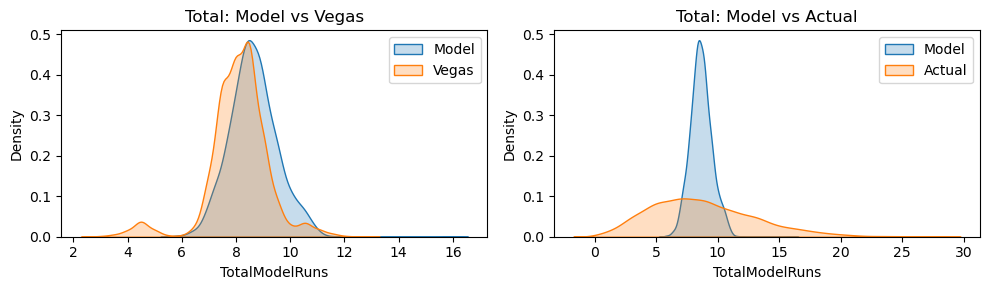

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs Vegas
sns.kdeplot(complete_gambling_df['TotalModelRuns'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(complete_gambling_df['TotalVegasRuns'], label='Vegas', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Total: Model vs Vegas")

# Right plot: Model vs Actual
sns.kdeplot(complete_gambling_df['TotalModelRuns'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(complete_gambling_df['TotalActualRuns'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Total: Model vs Actual")

plt.tight_layout()
plt.show()


##### Figure 1B. Home/Road

In [38]:
complete_gambling_df[['VisitorModelRuns', 'VisitorVegasRuns', 'VisitorActualRuns', 
                      'HomeModelRuns', 'HomeVegasRuns', 'HomeActualRuns']].describe()

,VisitorModelRuns,VisitorVegasRuns,VisitorActualRuns,HomeModelRuns,HomeVegasRuns,HomeActualRuns
count,2388.000000,2317.000000,2388.000000,2388.000000,2317.000000,2388.000000
mean,4.307709,3.891757,4.406198,4.322239,4.200486,4.397404
std,0.533893,1.004778,3.162542,0.531670,0.878448,3.018992
min,2.941468,1.175510,0.000000,2.608135,1.439394,0.000000
25%,3.937996,3.257143,2.000000,3.986111,3.642857,2.000000
50%,4.286706,3.827548,4.000000,4.289187,4.222243,4.000000
75%,4.631944,4.457143,6.000000,4.639881,4.843064,6.000000
max,6.482143,7.896546,20.000000,13.000000,6.924542,20.000000


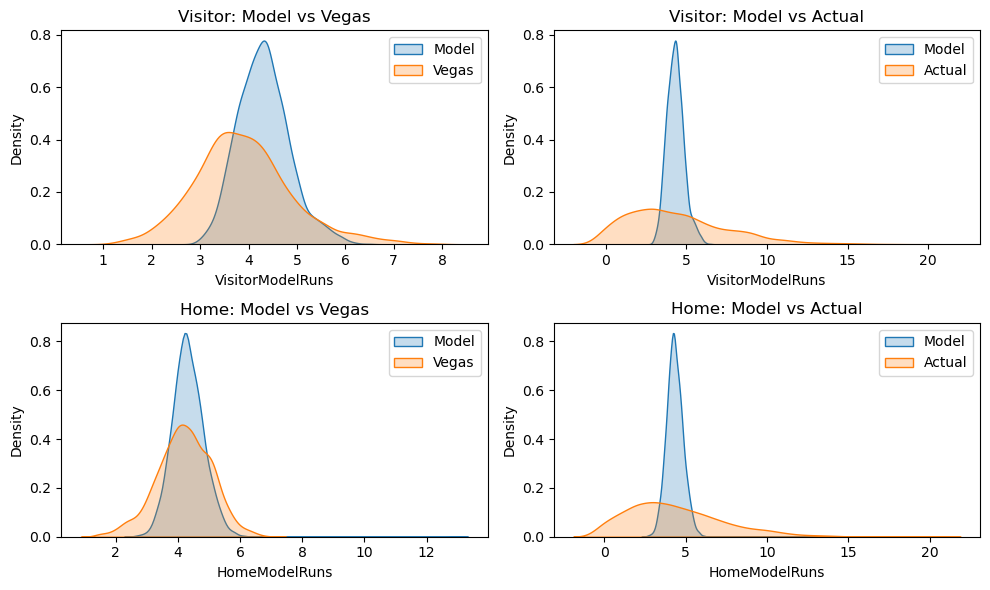

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns

# Bottom-left: Road Model vs Vegas
sns.kdeplot(complete_gambling_df['VisitorModelRuns'], label='Model', shade=True, ax=axes[0, 0])
sns.kdeplot(complete_gambling_df['VisitorVegasRuns'], label='Vegas', shade=True, ax=axes[0, 0])
axes[0, 0].legend()
axes[0, 0].set_title("Visitor: Model vs Vegas")

# Bottom-right: Road Model vs Actual
sns.kdeplot(complete_gambling_df['VisitorModelRuns'], label='Model', shade=True, ax=axes[0, 1])
sns.kdeplot(complete_gambling_df['VisitorActualRuns'], label='Actual', shade=True, ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Visitor: Model vs Actual")

# Top-left: Home Model vs Vegas
sns.kdeplot(complete_gambling_df['HomeModelRuns'], label='Model', shade=True, ax=axes[1, 0])
sns.kdeplot(complete_gambling_df['HomeVegasRuns'], label='Vegas', shade=True, ax=axes[1, 0])
axes[1, 0].legend()
axes[1, 0].set_title("Home: Model vs Vegas")

# Top-right: Home Model vs Actual
sns.kdeplot(complete_gambling_df['HomeModelRuns'], label='Model', shade=True, ax=axes[1, 1])
sns.kdeplot(complete_gambling_df['HomeActualRuns'], label='Actual', shade=True, ax=axes[1, 1])
axes[1, 1].legend()
axes[1, 1].set_title("Home: Model vs Actual")

plt.tight_layout()
plt.show()


##### Figure 1C. Underdog/Favorite

In [40]:
complete_gambling_df[['MyUnderdogModelRuns', 'UnderdogVegasRuns', 'MyUnderdogActualRuns', 
                      'MyFavoriteModelRuns', 'FavoriteVegasRuns', 'MyFavoriteActualRuns']].describe()

,MyUnderdogModelRuns,UnderdogVegasRuns,MyUnderdogActualRuns,MyFavoriteModelRuns,FavoriteVegasRuns,MyFavoriteActualRuns
count,2388.000000,2317.000000,2388.000000,2388.000000,2317.000000,2388.000000
mean,4.091586,3.443925,3.958543,4.538361,4.648318,4.842546
std,0.439207,0.656289,2.959218,0.524473,0.820131,3.155700
min,2.608135,1.175510,0.000000,3.046627,1.538095,0.000000
25%,3.791667,3.067739,2.000000,4.223958,4.172727,2.000000
50%,4.084821,3.477141,3.000000,4.508929,4.600985,4.000000
75%,4.364335,3.893405,6.000000,4.820437,5.127950,7.000000
max,5.672619,5.696329,20.000000,13.000000,7.896546,20.000000


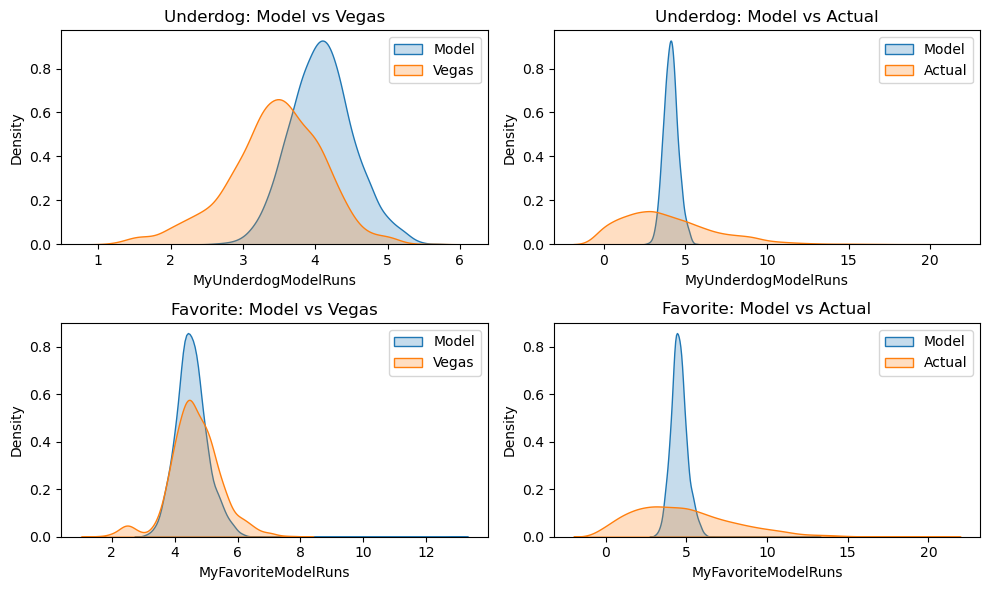

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2 rows, 2 columns

# Bottom-left: Road Model vs Vegas
sns.kdeplot(complete_gambling_df['MyUnderdogModelRuns'], label='Model', shade=True, ax=axes[0, 0])
sns.kdeplot(complete_gambling_df['UnderdogVegasRuns'], label='Vegas', shade=True, ax=axes[0, 0])
axes[0, 0].legend()
axes[0, 0].set_title("Underdog: Model vs Vegas")

# Bottom-right: Road Model vs Actual
sns.kdeplot(complete_gambling_df['MyUnderdogModelRuns'], label='Model', shade=True, ax=axes[0, 1])
sns.kdeplot(complete_gambling_df['MyUnderdogActualRuns'], label='Actual', shade=True, ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Underdog: Model vs Actual")

# Top-left: Home Model vs Vegas
sns.kdeplot(complete_gambling_df['MyFavoriteModelRuns'], label='Model', shade=True, ax=axes[1, 0])
sns.kdeplot(complete_gambling_df['FavoriteVegasRuns'], label='Vegas', shade=True, ax=axes[1, 0])
axes[1, 0].legend()
axes[1, 0].set_title("Favorite: Model vs Vegas")

# Top-right: Home Model vs Actual
sns.kdeplot(complete_gambling_df['MyFavoriteModelRuns'], label='Model', shade=True, ax=axes[1, 1])
sns.kdeplot(complete_gambling_df['MyFavoriteActualRuns'], label='Actual', shade=True, ax=axes[1, 1])
axes[1, 1].legend()
axes[1, 1].set_title("Favorite: Model vs Actual")

plt.tight_layout()
plt.show()


##### Figure 1D. Victory Margin

In [42]:
complete_gambling_df[['ModelDiff', 'VegasDiff', 'ActualDiff']].describe()

,ModelDiff,VegasDiff,ActualDiff
count,2388.000000,2317.000000,2388.000000
mean,0.446775,1.225022,3.533082
std,0.392471,0.934206,2.668564
min,0.000000,0.018752,1.000000
25%,0.182292,0.483644,1.000000
50%,0.373016,1.015873,3.000000
75%,0.631200,1.764411,5.000000
max,10.000000,4.857143,17.000000


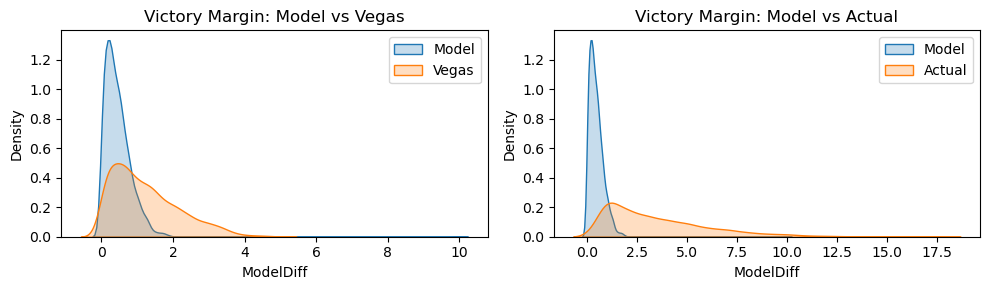

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))  # 1 row, 2 columns

# Left plot: Model vs Vegas
sns.kdeplot(complete_gambling_df['ModelDiff'], label='Model', shade=True, ax=axes[0])
sns.kdeplot(complete_gambling_df['VegasDiff'], label='Vegas', shade=True, ax=axes[0])
axes[0].legend()
axes[0].set_title("Victory Margin: Model vs Vegas")

# Right plot: Model vs Actual
sns.kdeplot(complete_gambling_df['ModelDiff'], label='Model', shade=True, ax=axes[1])
sns.kdeplot(complete_gambling_df['ActualDiff'], label='Actual', shade=True, ax=axes[1])
axes[1].legend()
axes[1].set_title("Victory Margin: Model vs Actual")

plt.tight_layout()
plt.show()

##### Figure 1E. Time

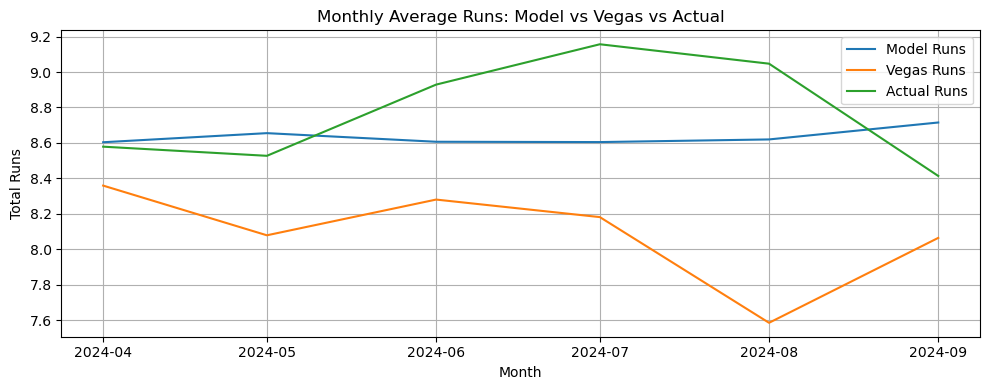

In [55]:
# Step 1: Convert date column to datetime
complete_gambling_df['date'] = pd.to_datetime(complete_gambling_df['date'], format='%Y%m%d')

# Step 2: Create a Year-Month column
complete_gambling_df['year_month'] = complete_gambling_df['date'].dt.to_period('M')

# Step 3: Group by Year-Month and average the relevant columns
monthly_means = complete_gambling_df.groupby('year_month')[
    ['TotalModelRuns', 'TotalVegasRuns', 'TotalActualRuns']
].mean().reset_index()

# Step 4: Convert year_month back to datetime for plotting
monthly_means['year_month'] = monthly_means['year_month'].dt.to_timestamp()


monthly_means = monthly_means[monthly_means['year_month'] > '2024-03-01']

# Step 5: Plot
plt.figure(figsize=(10, 4))
plt.plot(monthly_means['year_month'], monthly_means['TotalModelRuns'], label='Model Runs')
plt.plot(monthly_means['year_month'], monthly_means['TotalVegasRuns'], label='Vegas Runs')
plt.plot(monthly_means['year_month'], monthly_means['TotalActualRuns'], label='Actual Runs')

plt.title('Monthly Average Runs: Model vs Vegas vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##### Figure 1F. Venue

In [45]:
complete_gambling_df = complete_gambling_df.merge(venue_map_df[['id', 'name']], left_on='venue_id', right_on='id', how='left')

In [46]:
complete_gambling_df.groupby(['venue_id', 'name'])[['TotalModelRuns', 'TotalVegasRuns', 'TotalActualRuns']].mean().reset_index()

,venue_id,name,TotalModelRuns,TotalVegasRuns,TotalActualRuns
0,1,Angel Stadium,8.729448,8.245732,8.962963
1,2,Oriole Park at Camden Yards,8.714149,8.148899,8.912500
2,3,Fenway Park,9.319520,8.842660,9.443038
3,4,Rate Field,8.351125,8.226666,8.171053
4,5,Progressive Field,8.151180,7.666344,8.740260
5,7,Kauffman Stadium,8.935442,8.359786,9.037037
6,10,Oakland Coliseum,8.306241,7.615203,8.641975
7,12,Tropicana Field,7.638264,7.652617,7.790123
8,14,Rogers Centre,8.801281,7.975759,9.000000
9,15,Chase Field,9.857461,8.566652,10.728395


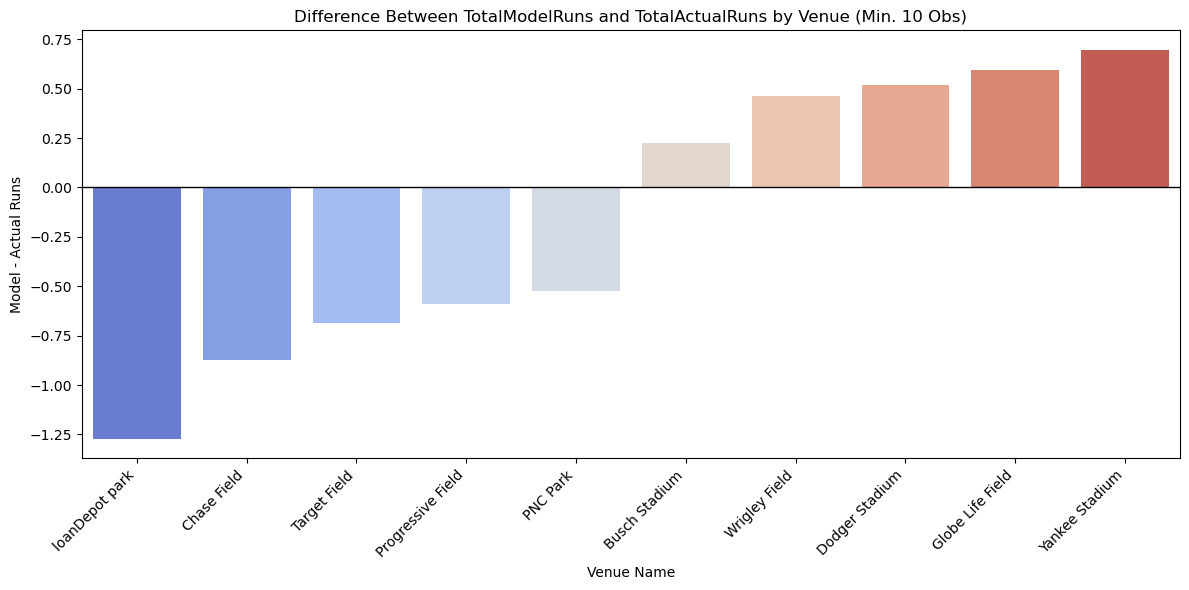

In [47]:
# Step 1: Group and aggregate
grouped = complete_gambling_df.groupby(['venue_id', 'name']).agg(
    TotalModelRuns=('TotalModelRuns', 'mean'),
    TotalActualRuns=('TotalActualRuns', 'mean'),
    count=('TotalModelRuns', 'size')  # Could be any column
).reset_index()

# Step 2: Filter for at least 10 observations
grouped = grouped[grouped['count'] >= 10]

# Step 3: Compute the difference
grouped['Diff'] = grouped['TotalModelRuns'] - grouped['TotalActualRuns']

# Step 4: Get top and bottom 5
sorted_grouped = grouped.sort_values('Diff')
top_bottom = pd.concat([sorted_grouped.head(5), sorted_grouped.tail(5)])

# Step 5: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_bottom, x='name', y='Diff', palette='coolwarm')
plt.axhline(0, color='black', linewidth=1)
plt.title('Difference Between TotalModelRuns and TotalActualRuns by Venue (Min. 10 Obs)')
plt.ylabel('Model - Actual Runs')
plt.xlabel('Venue Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##### 1G. Weather

In [48]:
# Might not be terribly helpful, but bucketing HRs and seeing if that affects runs might be interesting.

### 2. Bets

##### Graph by Bin

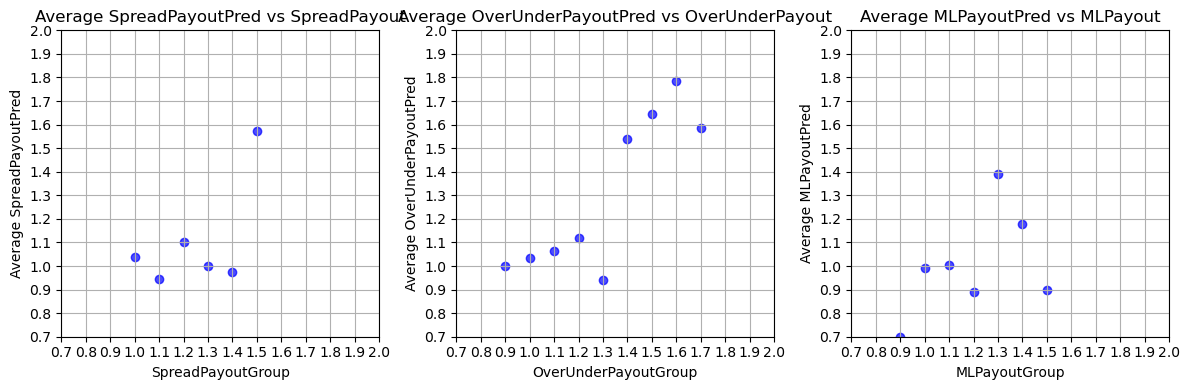

			Spread: 1.021					OverUnder: 1.084				Money Line: 0.998


In [49]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(complete_gambling_df, 'Spread', ax=axes[0])
payout_plotter(complete_gambling_df, 'OverUnder', ax=axes[1])
payout_plotter(complete_gambling_df, 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = complete_gambling_df['SpreadPayout'].mean()
OverUnderMean = complete_gambling_df['OverUnderPayout'].mean()
MLMean = complete_gambling_df['MLPayout'].mean()
print(f"\t\t\tSpread: {round(SpreadMean, 3)}\t\t\t\t\tOverUnder: {round(OverUnderMean, 3)}\t\t\t\tMoney Line: {round(MLMean, 3)}")

##### Significance Test

Main Bets

In [50]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "Spread", 1.0, 0.05)
print("Spread:   ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "OverUnder", 1.0, 0.05)
print("OverUnder:", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "ML", 1.0, 0.05)
print("ML:       ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

Spread:    Average Payout: 1.01974, Sample Size: 1531, P-Value: 0.20525702686420122, Significant: No
OverUnder: Average Payout: 1.08573, Sample Size: 1788, P-Value: 4.871041440458251e-05, Significant: Yes
ML:        Average Payout: 0.9971, Sample Size: 1616, P-Value: 1.0, Significant: No


Spread

In [51]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "Spread", 1.0, 0.05)
print("Spread:   ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('SpreadSide == "Underdog"'), "Spread", 1.0, 0.05)
print("Underdog: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_underdog_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('SpreadSide == "Favorite"'), "Spread", 1.0, 0.05)
print("Favorite: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_favorite_list = [average_payout, sample_size, p_value, significant]

Spread:    Average Payout: 1.01974, Sample Size: 1531, P-Value: 0.20525702686420122, Significant: No
Underdog:  Average Payout: 0.99036, Sample Size: 1285, P-Value: 1.0, Significant: No
Favorite:  Average Payout: 1.17318, Sample Size: 246, P-Value: 0.015449005625212588, Significant: Yes


Over/Under

In [52]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "OverUnder", 1.0, 0.05)
print("OverUnder:", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('OverUnderPick == "Over"'), "OverUnder", 1.0, 0.05)
print("Over:     ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_over_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('OverUnderPick == "Under"'), "OverUnder", 1.0, 0.05)
print("Under:    ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_under_list = [average_payout, sample_size, p_value, significant]

OverUnder: Average Payout: 1.08573, Sample Size: 1788, P-Value: 4.871041440458251e-05, Significant: Yes
Over:      Average Payout: 1.13596, Sample Size: 761, P-Value: 1.978878655857152e-05, Significant: Yes
Under:     Average Payout: 1.0485, Sample Size: 1027, P-Value: 0.049613370338957456, Significant: Yes


Moneyline

In [53]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "ML", 1.0, 0.05)
print("ML:      ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('MLSide == "Underdog"'), "ML", 1.0, 0.05)
print("Underdog:", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_away_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('MLSide == "Favorite"'), "ML", 1.0, 0.05)
print("Favorite:", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_home_list = [average_payout, sample_size, p_value, significant]

ML:       Average Payout: 0.9971, Sample Size: 1616, P-Value: 1.0, Significant: No
Underdog: Average Payout: 1.1, Sample Size: 165, P-Value: 0.07097429690514043, Significant: No
Favorite: Average Payout: 0.97499, Sample Size: 1396, P-Value: 1.0, Significant: No
